# Generator

In [ ]:
# building the vertex_index generator model, vertex_coordinates generator model and encoded_color generator model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, MultiHeadAttention, Lambda, Embedding, Reshape

VI_input_layer = Input(shape=(3,))
VI_layer = Dense(300, activation = 'relu')(VI_input_layer)
VI_layer = Dense(9, activation = 'relu')(VI_layer)
VI_layer_output = Dense(3, activation = 'relu')(VI_layer)
VI_layer_emb = Reshape((3, 3))(VI_layer)
# VI_layer_emb = Embedding(input_dim=120, output_dim=3, input_length=3, name = 'VI_embedding')(VI_layer_output)

VC_input_layer = Input(shape=(3,3))
VC_layer_MHA = MultiHeadAttention(num_heads=128, key_dim=3, name = 'MHA_VC_1')(VC_input_layer, tf.transpose(VI_layer_emb, perm=[0, 2, 1]), tf.transpose(VI_layer_emb, perm=[0, 2, 1]))
VC_layer_MHA = MultiHeadAttention(num_heads=64, key_dim=2, name = 'MHA_VC_2')(VC_layer_MHA, VC_layer_MHA)
VC_layer_output = Reshape(target_shape=(3,3))(VC_layer_MHA)

colour_input = Input(shape=(3,))
color_layer_emb = Embedding(input_dim=256, output_dim=3, name = 'col_embedding')(colour_input)
color_layer_MHA = MultiHeadAttention(num_heads=128, key_dim=3, name = 'MHA_col_1')(color_layer_emb, tf.transpose(VI_layer_emb, perm=[0, 2, 1]), tf.transpose(VI_layer_emb, perm=[0, 2, 1]))
color_layer_MHA = MultiHeadAttention(num_heads=64, key_dim=2, name = 'MHA_col_2')(color_layer_MHA, color_layer_MHA)
color_layer = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True))(color_layer_MHA)
color_layer_output = Reshape(target_shape=(3,))(color_layer)
# Clip the color_layer_output between 0 and 255
clipped_color_layer_output = tf.clip_by_value(color_layer_output, clip_value_min=0, clip_value_max=255)


generator_model = tf.keras.Model(inputs=[VI_input_layer, VC_input_layer, colour_input], outputs=[VI_layer_output, VC_layer_output, clipped_color_layer_output])

generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 300)                  1200      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 9)                    2709      ['dense[0][0]']               
                                                                                                  
 reshape (Reshape)           (None, 3, 3)                 0         ['dense_1[0][0]']             
                                                                                              

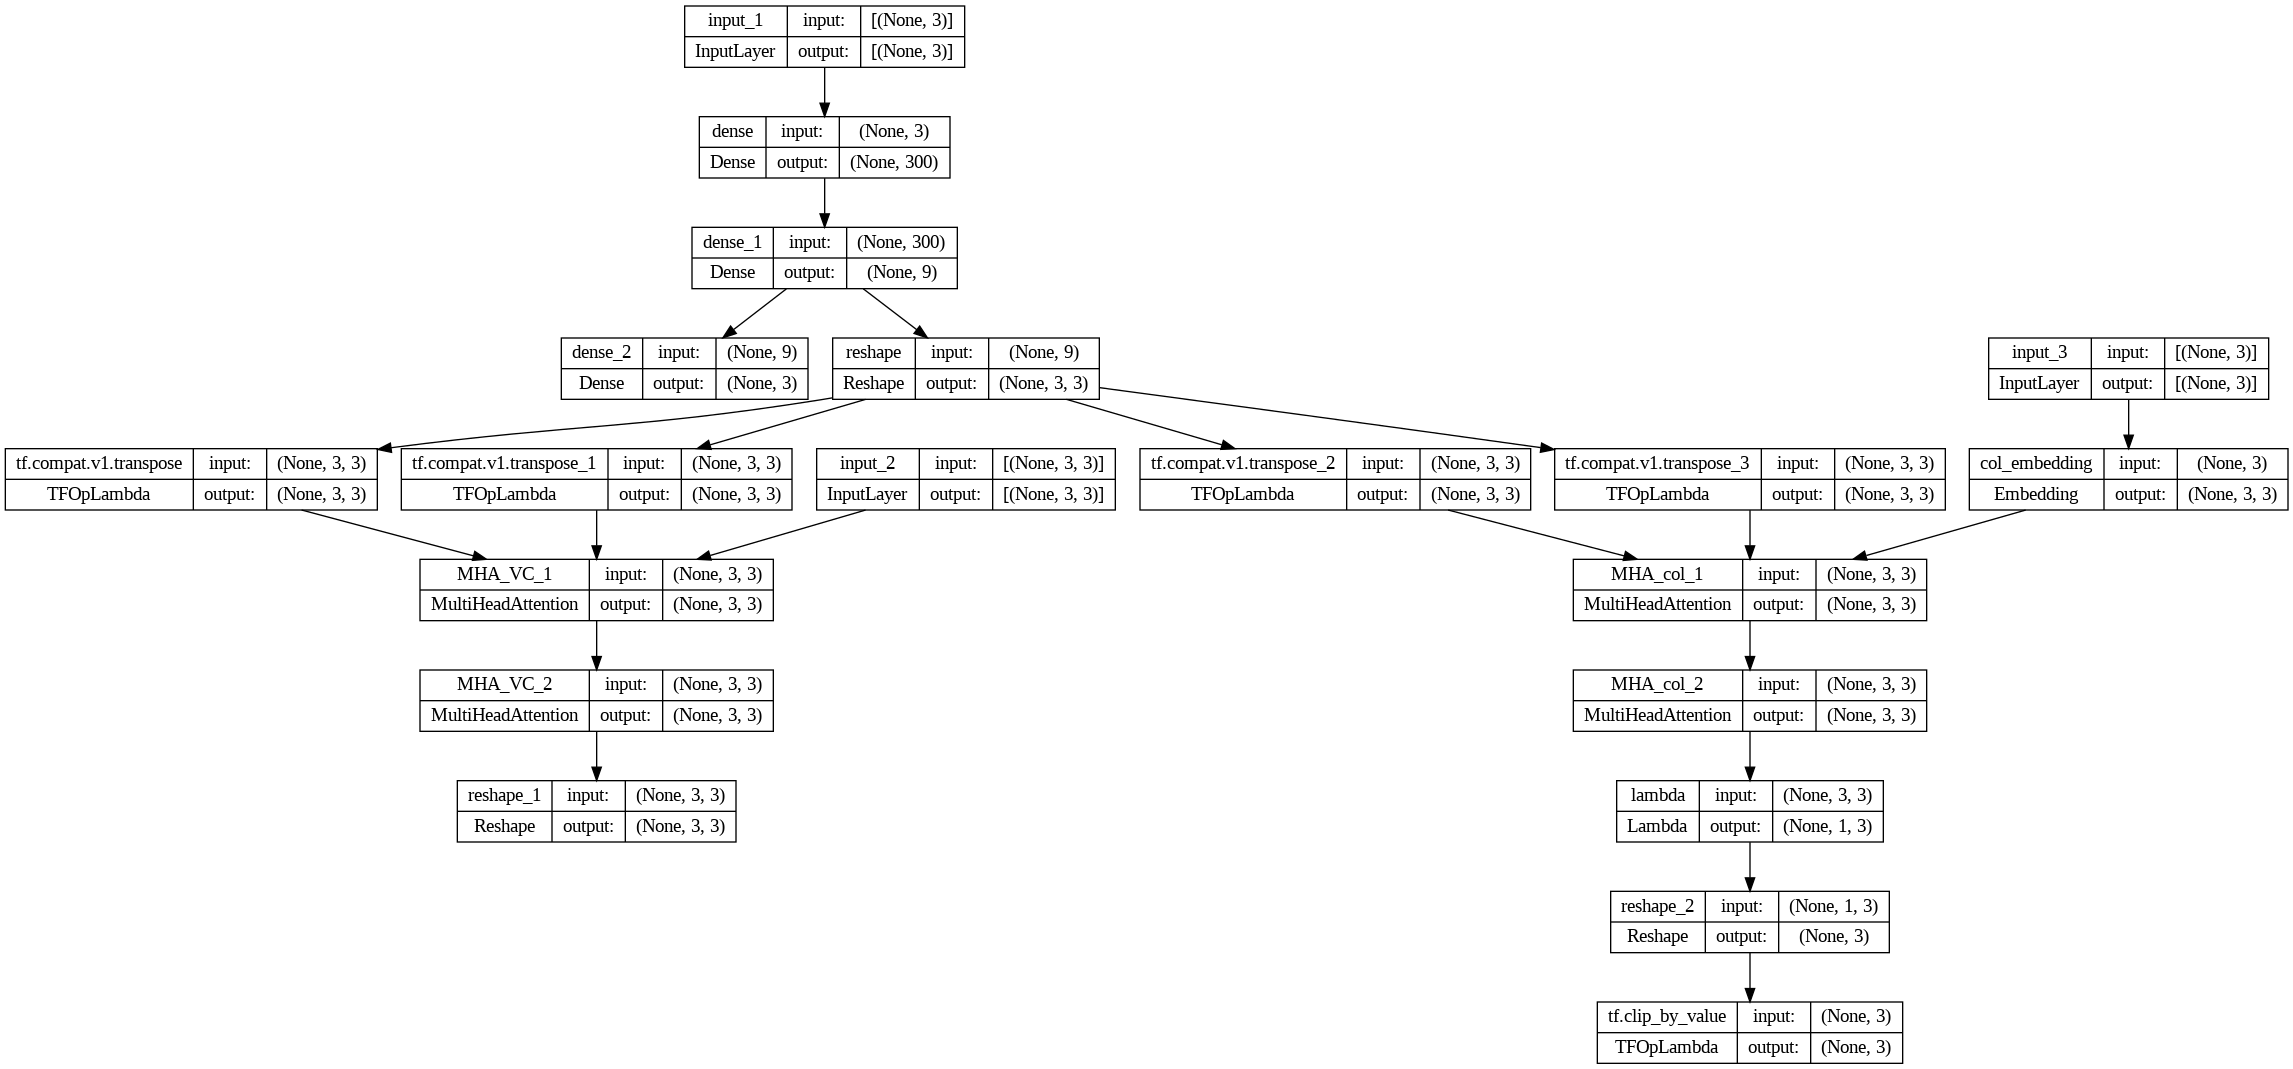

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(generator_model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

# Discriminator

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda, Conv2D, Conv1D


VI_layer_inputs = Input(shape=(3,))
VC_layer_inputs = Input(shape=(3,3))
color_inputs = Input(shape=(3,))

# color_layer = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True))(color_layer_output)
# VC_Col = Concatenate(axis=1)([VC_layer_output, color_layer])


# VI_layer = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', name='conv3d')(tf.expand_dims(VI_layer_inputs, axis=-1))
# VI_layer = Flatten()(VI_layer)
VI_layer = Dense(300, activation='relu')(VI_layer_inputs)
VI_layer = Dense(200, activation='relu')(VI_layer)
VI_layer = Dense(100, activation='relu')(VI_layer)
VI_layer_output = Dense(1)(VI_layer)

VC_layer = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(tf.expand_dims(VC_layer_inputs, axis=-1))
VC_layer = Flatten()(VC_layer)
VC_layer = Dense(64, activation='relu')(VC_layer)
VC_layer_output = Dense(1)(VC_layer)

color_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(tf.expand_dims(color_inputs, axis=-1))
color_layer = Flatten()(color_layer)
color_layer = Dense(64, activation='relu')(color_layer)
color_layer_output = Dense(1)(color_layer)

discriminator_model = tf.keras.Model(inputs=[VI_layer_inputs, VC_layer_inputs, color_inputs], outputs=[VI_layer_output, VC_layer_output, color_layer_output])

discriminator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 3, 3)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 3, 3, 1)              0         ['input_5[0][0]']             
 )                                                                                          

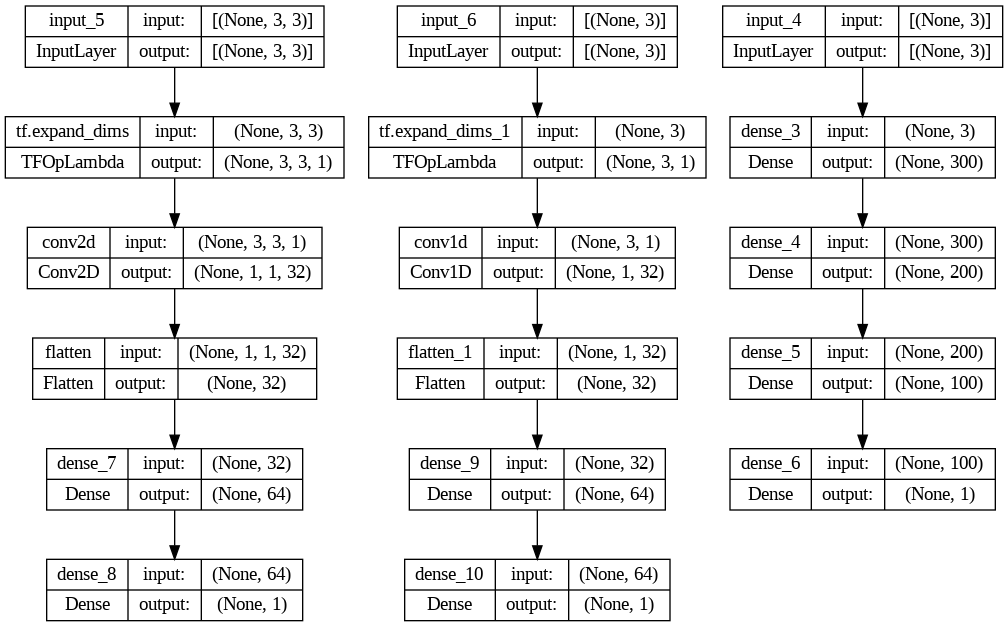

In [ ]:
plot_model(discriminator_model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

# Loss Function

In [ ]:
def loss_generator(fake_output):
  g_loss_VI = -1. * tf.math.reduce_mean(fake_output[0])
  g_loss_VC = -1. * tf.math.reduce_mean(fake_output[1])
  g_loss_color = -1. * tf.math.reduce_mean(fake_output[2])
  g_loss = g_loss_VI + g_loss_VC + g_loss_color
  return g_loss

In [ ]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss_VI = tf.math.reduce_mean(fake_output[0]) - tf.math.reduce_mean(real_output[0]) + c_lambda * gradient_penalty[0]
  d_loss_VC = tf.math.reduce_mean(fake_output[1]) - tf.math.reduce_mean(real_output[1]) + c_lambda * gradient_penalty[1]
  d_loss_color = tf.math.reduce_mean(fake_output[2]) - tf.math.reduce_mean(real_output[2]) + c_lambda * gradient_penalty[2]
  d_loss = d_loss_VI + d_loss_VC + d_loss_color
  return d_loss

# Gradient Scores

In [ ]:
def interpolated_scores(real, fake, epsilon):

  interpolated_VI = real[0] * epsilon[0] + fake[0] * (1 - epsilon[0])
  interpolated_VC = real[1] * epsilon[1] + fake[1] * (1 - epsilon[1])
  interpolated_color = real[2] * epsilon[2]  + fake[2] * (1 - epsilon[2])

  return interpolated_VI, interpolated_VC, interpolated_color

In [ ]:
@tf.function
def gradient_penalty_VI(interpolated_VI, interpolated_VC, interpolated_color):

  with tf.GradientTape() as tape:
    tape.watch(interpolated_VI)
    score_VI, _, _ = discriminator_model([interpolated_VI, interpolated_VC, interpolated_color])

  # score_VI = tf.cast(score_VI, dtype=tf.float64)
  print(f'scores_VI: {score_VI.dtype}')

  gradient_0 = tape.gradient(score_VI, interpolated_VI)
  print(f'gradient_0: {gradient_0.dtype}')

  gradient_norm_0 = tf.norm(gradient_0)
  print(f'gradient_norm_0: {gradient_norm_0.dtype}')

  gp_0 = tf.math.reduce_mean((gradient_0 - 1)**2)

  return gp_0

In [ ]:
@tf.function
def gradient_penalty_VC(interpolated_VI, interpolated_VC, interpolated_color):

  with tf.GradientTape() as tape:
    tape.watch(interpolated_VC)
    _, score_VC, _ = discriminator_model([interpolated_VI, interpolated_VC, interpolated_color])

  # score_VC = tf.cast(score_VC, dtype=tf.float32)
  print(f'scores_VC: {score_VC}')

  gradient_1 = tape.gradient(score_VC, interpolated_VC)
  print(f'gradient_1: {gradient_1}')

  gradient_norm_1 = tf.norm(gradient_1)
  print(f'gradient_norm_1: {gradient_norm_1}')

  gp_1 = tf.math.reduce_mean((gradient_norm_1 - 1)**2)

  return gp_1

In [ ]:
@tf.function
def gradient_penalty_color(interpolated_VI, interpolated_VC, interpolated_color):

  with tf.GradientTape() as tape:
    tape.watch(interpolated_color)
    _, _, score_color = discriminator_model([interpolated_VI, interpolated_VC, interpolated_color])

  # score_color = tf.cast(score_color, dtype=tf.float64)
  print(f'scores_color: {score_color}')

  gradient_2 = tape.gradient(score_color, interpolated_color)
  print(f'gradient_2: {gradient_2}')

  gradient_norm_2 = tf.norm(gradient_2)
  print(f'gradient_norm_2: {gradient_norm_2}')

  gp_2 = tf.math.reduce_mean((gradient_norm_2 - 1)**2)

  return gp_2

# Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

# Training Steps

In [ ]:
def training_step(VI, VC, color):
  noise_VI = tf.random.uniform([7162,3,], minval=0, maxval=3592) # batch changes
  noise_VC = tf.random.uniform([7162,3,3])
  noise_color = np.random.uniform(0, 1, size=(7162, 3))
  # noise_color = np.random.rand(120, 3)

  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    print(f"d_tape {i} is started")
    with tf.GradientTape() as d_tape:
      generated_value_VI, generated_value_VC, generated_value_color = generator_model([noise_VI, noise_VC, noise_color], training = True)
      print(f"d_tape {i} generator model working properly")

      real_VI_output, real_VC_output, real_color_output = discriminator_model([VI, VC, color], training = True)
      print(f"d_tape {i} discriminator model (real data) working properly")

      fake_VI_output, fake_VC_output, fake_color_output = discriminator_model([generated_value_VI, generated_value_VC, generated_value_color], training = True)
      print(f"d_tape {i} discriminator model (fake data) working properly")

      epsilon_0 = tf.random.normal([7162, 1], 0.0, 1.0)  # Remember this line for batch size
      epsilon_1 = tf.random.normal([7162, 1, 1], 0.0, 1.0)
      epsilon_2 = tf.random.normal([7162, 1], 0.0, 1.0)
      print(f"d_tape {i} epsilons created successfully")


      interpolated_VI, interpolated_VC, interpolated_color = interpolated_scores([VI, VC, color], [generated_value_VI, generated_value_VC, generated_value_color], [epsilon_0, epsilon_1, epsilon_2])
      print(f"d_tape {i} interpolated data created successfully")

      gp_0 = gradient_penalty_VI(interpolated_VI, interpolated_VC, interpolated_color )
      gp_1 = gradient_penalty_VC(interpolated_VI, interpolated_VC, interpolated_color )
      gp_2 = gradient_penalty_color(interpolated_VI, interpolated_VC, interpolated_color )
      print(f"d_tape {i} gp's calculated successfully")

      d_loss = loss_discriminator([real_VI_output, real_VC_output, real_color_output], [fake_VI_output, fake_VC_output, fake_color_output], [gp_0, gp_1, gp_2])
      print(f"d_tape {i} d_loss calculated")

    discriminator_gradients = d_tape.gradient(d_loss, discriminator_model.trainable_variables)
    print("discriminator gradients calcuated successfully")

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))
    print("disccriminator gradients updated successfully")

  with tf.GradientTape() as g_tape:
    generated_value_VI, generated_value_VC, generated_value_color = generator_model([noise_VI, noise_VC, noise_color], training = True)
    print("g_tape generator model working properly")

    fake_VI_output, fake_VC_output, fake_color_output = discriminator_model([generated_value_VI, generated_value_VC, generated_value_color], training = True)
    print("g_tape discriminator model (fake data) working properly")

    g_loss = loss_generator([fake_VI_output, fake_VC_output, fake_color_output])
    print("generator loss calcuated successfully")

  generator_gradients = g_tape.gradient(g_loss, generator_model.trainable_variables)
  print("generator gradients calcuated successfully")

  generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
  print("generator gradients updated successfully")


# Data Prep

In [ ]:
from tensorflow.keras.layers import Activation
import tensorflow as tf

def dataset_prep(data):

  # getting vertex coordinates
  data['vertex_coordinate_0'] = data['vertex_coordinate_0'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))
  data['vertex_coordinate_1'] = data['vertex_coordinate_1'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))
  data['vertex_coordinate_2'] = data['vertex_coordinate_2'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))

  vertex_coordinate_0 = np.array(data['vertex_coordinate_0'].tolist())
  vertex_coordinate_1 = np.array(data['vertex_coordinate_1'].tolist())
  vertex_coordinate_2 = np.array(data['vertex_coordinate_2'].tolist())

  vertices_stack = np.stack((vertex_coordinate_0, vertex_coordinate_1, vertex_coordinate_2), axis=1)
  vertices_coordinates = tf.Variable(vertices_stack)

  # getting vertec indexes
  vertices_stack = np.stack((data['vertex_index_0'], data['vertex_index_1'], data['vertex_index_2']), axis=1)
  vertice_indexes = tf.Variable(vertices_stack, dtype=tf.float32)


  # getting color
  data['color'] = data['color'].apply(lambda x: np.array(x.split(','), dtype=np.float32))
  color_arr = np.array(data['color'].tolist())
  color = tf.Variable(color_arr)

  # getting batch size
  batch_size = len(data['vertex_coordinate_0'])

  return vertice_indexes, vertices_coordinates, color, batch_size

# Training code

In [ ]:
import time

# def train(dataset, epochs):
def train(epochs, runs):
  print("\n\nready to begin\n\n")
  l = 0
  for i in range(runs):
    print(f"------------------------------------------- epoch {l} -------------------------------------------------")
    k=0
    for epoch in range(epochs):
      initial = time.time()
      print(f"-------------------------- batch {k} --------------------------")

      file_path = f'output_file_adj_{epoch*10}.csv'
      data = pd.read_csv(file_path)

      VI, VC, col, batch_size = dataset_prep(data)

      print("VI, VC, col extracted")
      training_step(VI, VC, col)

      print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))
      k+=1
    l+=1
  #display.clear_output(wait = True)
  # create_and_save_images(generator, epochs, seed)
  generator_model.save('generator.h5')

# Train Model

In [ ]:
epochs = 32
noise_dim = 7162 # batch changes

In [ ]:
import pandas as pd
import numpy as np
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

file_path = 'output_file_adj_0.csv'
data = pd.read_csv(file_path)

train(epochs, 100)

Streaming output truncated to the last 5000 lines.
d_tape 1 interpolated data created successfully
d_tape 1 gp's calculated successfully
d_tape 1 d_loss calculated
discriminator gradients calcuated successfully
disccriminator gradients updated successfully
d_tape 2 is started
d_tape 2 generator model working properly
d_tape 2 discriminator model (real data) working properly
d_tape 2 discriminator model (fake data) working properly
d_tape 2 epsilons created successfully
d_tape 2 interpolated data created successfully
d_tape 2 gp's calculated successfully
d_tape 2 d_loss calculated
discriminator gradients calcuated successfully
disccriminator gradients updated successfully
g_tape generator model working properly
g_tape discriminator model (fake data) working properly
generator loss calcuated successfully
generator gradients calcuated successfully
generator gradients updated successfully
Time taken to process epoch 29 was 1.4736390113830566 seconds
-------------------------- batch 29 ----

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


generator gradients calcuated successfully
generator gradients updated successfully
Time taken to process epoch 32 was 1.255457878112793 seconds


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Given code
noise_VI = tf.random.uniform([7162,3,], minval=0, maxval=3592)  #batch changes
noise_VC = tf.random.uniform([7162,3,3])
noise_color = np.random.uniform(0, 1, size=(7162, 3))

generated_value_VI, generated_value_VC, generated_value_color = generator_model([noise_VI, noise_VC, noise_color], training=True)

generated_value_VC[0,0:1,0], generated_value_VC[0]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-10.1674595], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-10.1674595,  -5.9544096,   6.0242143],
        [-10.274498 ,  -5.974945 ,   6.045816 ],
        [-10.043023 ,  -5.965708 ,   6.0052495]], dtype=float32)>)

# Evaluation

In [ ]:
file_path = 'output_file_adj_0.csv'
data = pd.read_csv(file_path)

data.head()

,vertex_index_0,vertex_index_1,vertex_index_2,vertex_coordinate_0,vertex_coordinate_1,vertex_coordinate_2,color
0,853,892,3530,"(-12.2745, -6.8547, 4.1986)","(-12.2159, -6.6538, 4.4674)","(-12.1367, -6.7317, 4.1713)","1.0, 1.0, 1.0"
1,1797,1798,892,"(-12.3469, -6.7453, 4.4965)","(-12.3208, -6.58, 4.8083)","(-12.2159, -6.6538, 4.4674)","1.0, 1.0, 1.0"
2,1,892,1798,"(-12.1982, -6.5039, 4.8156)","(-12.2159, -6.6538, 4.4674)","(-12.3208, -6.58, 4.8083)","1.0, 1.0, 1.0"
3,1799,3530,892,"(-12.1016, -6.5692, 4.4965)","(-12.1367, -6.7317, 4.1713)","(-12.2159, -6.6538, 4.4674)","1.0, 1.0, 1.0"
4,1,893,1799,"(-12.1982, -6.5039, 4.8156)","(-12.0513, -6.5187, 4.584)","(-12.1016, -6.5692, 4.4965)","1.0, 1.0, 1.0"


In [ ]:
data['vertex_coordinate_0'] = data['vertex_coordinate_0'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))
data['vertex_coordinate_1'] = data['vertex_coordinate_1'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))
data['vertex_coordinate_2'] = data['vertex_coordinate_2'].apply(lambda x: np.array(x[1:-1].split(','), dtype=np.float32))

vertex_coordinate_0 = np.array(data['vertex_coordinate_0'].tolist())
vertex_coordinate_1 = np.array(data['vertex_coordinate_1'].tolist())
vertex_coordinate_2 = np.array(data['vertex_coordinate_2'].tolist())

vertices_stack = np.stack((vertex_coordinate_0, vertex_coordinate_1, vertex_coordinate_2), axis=1)
vertices_coordinates = tf.Variable(vertices_stack)

vertices_coordinates[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-12.2745,  -6.8547,   4.1986],
       [-12.2159,  -6.6538,   4.4674],
       [-12.1367,  -6.7317,   4.1713]], dtype=float32)>

#100 epochs

In [ ]:
vertex_coordinate_0[0], vertex_coordinate_1[0], vertex_coordinate_2[0]

(array([-12.2745,  -6.8547,   4.1986], dtype=float32),
 array([-12.2159,  -6.6538,   4.4674], dtype=float32),
 array([-12.1367,  -6.7317,   4.1713], dtype=float32))

In [ ]:
noise_VC[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.5128474 , 0.6406696 , 0.43576598],
       [0.83115053, 0.7572057 , 0.4301672 ],
       [0.01714194, 0.26466942, 0.14640784]], dtype=float32)>

In [ ]:
generated_value_VC[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-10.1674595,  -5.9544096,   6.0242143],
       [-10.274498 ,  -5.974945 ,   6.045816 ],
       [-10.043023 ,  -5.965708 ,   6.0052495]], dtype=float32)>

# again 100 epochs

In [ ]:
vertex_coordinate_0[0], vertex_coordinate_1[0], vertex_coordinate_2[0]

(array([-12.2745,  -6.8547,   4.1986], dtype=float32),
 array([-12.2159,  -6.6538,   4.4674], dtype=float32),
 array([-12.1367,  -6.7317,   4.1713], dtype=float32))

In [ ]:
noise_VC[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.5128474 , 0.6406696 , 0.43576598],
       [0.83115053, 0.7572057 , 0.4301672 ],
       [0.01714194, 0.26466942, 0.14640784]], dtype=float32)>

In [ ]:
generated_value_VC[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-10.1674595,  -5.9544096,   6.0242143],
       [-10.274498 ,  -5.974945 ,   6.045816 ],
       [-10.043023 ,  -5.965708 ,   6.0052495]], dtype=float32)>

In [ ]:
for i in range(20):
  print(f'----------------------------{i}----------------------------')
  print('actual')
  print(vertex_coordinate_0[i], vertex_coordinate_1[i], vertex_coordinate_2[i])
  print('Predicted')
  print(generated_value_VC[i])


----------------------------0----------------------------
actual
[-12.2745  -6.8547   4.1986] [-12.2159  -6.6538   4.4674] [-12.1367  -6.7317   4.1713]
Predicted
tf.Tensor(
[[-10.1674595  -5.9544096   6.0242143]
 [-10.274498   -5.974945    6.045816 ]
 [-10.043023   -5.965708    6.0052495]], shape=(3, 3), dtype=float32)
----------------------------1----------------------------
actual
[-12.3469  -6.7453   4.4965] [-12.3208  -6.58     4.8083] [-12.2159  -6.6538   4.4674]
Predicted
tf.Tensor(
[[-11.642733   -6.670409    6.4585094]
 [-11.612545   -6.658717    6.446953 ]
 [-11.346753   -6.579368    6.293302 ]], shape=(3, 3), dtype=float32)
----------------------------2----------------------------
actual
[-12.1982  -6.5039   4.8156] [-12.2159  -6.6538   4.4674] [-12.3208  -6.58     4.8083]
Predicted
tf.Tensor(
[[-10.2623415  -5.89221     6.6192374]
 [-10.24122    -5.920479    6.611492 ]
 [-10.306046   -5.921831    6.656149 ]], shape=(3, 3), dtype=float32)
----------------------------3--------

In [ ]:
generated_value_VC

<tf.Tensor: shape=(7162, 3, 3), dtype=float32, numpy=
array([[[-10.1674595,  -5.9544096,   6.0242143],
        [-10.274498 ,  -5.974945 ,   6.045816 ],
        [-10.043023 ,  -5.965708 ,   6.0052495]],

       [[-11.642733 ,  -6.670409 ,   6.4585094],
        [-11.612545 ,  -6.658717 ,   6.446953 ],
        [-11.346753 ,  -6.579368 ,   6.293302 ]],

       [[-10.2623415,  -5.89221  ,   6.6192374],
        [-10.24122  ,  -5.920479 ,   6.611492 ],
        [-10.306046 ,  -5.921831 ,   6.656149 ]],

       ...,

       [[-12.796708 ,  -8.800618 ,   5.001304 ],
        [-14.085741 ,  -7.427013 ,   3.7896678],
        [ -7.9680467,  -5.218723 ,   7.536135 ]],

       [[ -9.277973 ,  -5.957596 ,   4.667269 ],
        [ -9.41471  ,  -6.3137507,   4.5179935],
        [ -9.418611 ,  -5.963265 ,   4.7308254]],

       [[ -9.73305  ,  -5.647374 ,   5.025528 ],
        [ -9.54927  ,  -5.8232737,   5.0825233],
        [ -9.650635 ,  -5.7502875,   5.0576797]]], dtype=float32)>

In [ ]:
import numpy as np

tensor = generated_value_color

# Convert tf.Tensor to NumPy array
array = tensor.numpy()

# Reshape the array to 2D, as CSV file can only handle 2D data
array_2d = array.reshape(-1, array.shape[-1])

# Save NumPy array to CSV file
np.savetxt("generated_value_color.csv", array_2d, delimiter=",")


In [ ]:
generated_value_VI

<tf.Tensor: shape=(7162, 3), dtype=float32, numpy=
array([[2777.675  , 3123.5854 , 1539.0728 ],
       [ 542.0075 , 1428.972  , 2827.3142 ],
       [ 591.3142 , 1012.15826, 2032.9344 ],
       ...,
       [ 439.56488, 2791.9075 ,  939.9455 ],
       [3409.7483 , 1783.6239 , 3251.6536 ],
       [ 373.32913, 1153.9401 , 2435.3572 ]], dtype=float32)>

In [ ]:
generated_value_color

<tf.Tensor: shape=(7162, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

# Save model

In [ ]:
generator_model.save('generator.h5')

In [ ]:
discriminator_model.save('discrminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
vertices_stack = np.stack((data['vertex_index_0'], data['vertex_index_1'], data['vertex_index_2']), axis=1)
vertice_indexes = tf.Variable(vertices_stack, dtype=tf.float32)

vertice_indexes[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 853.,  892., 3530.], dtype=float32)>

In [ ]:
data['vertex_index_0'][0], data['vertex_index_1'][0], data['vertex_index_2'][0]


(853, 892, 3530)

In [ ]:
vertices_stack[0]

array([ 853,  892, 3530])

In [ ]:
generated_value_VI[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2777.675 , 3123.5854, 1539.0728], dtype=float32)>